<a href="https://colab.research.google.com/github/pascal-maker/segment-anything/blob/main/sam2ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [ ]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)

In [ ]:
image = Image.open('/content/val_batch0_pred.jpg')
image = np.array(image.convert("RGB"))

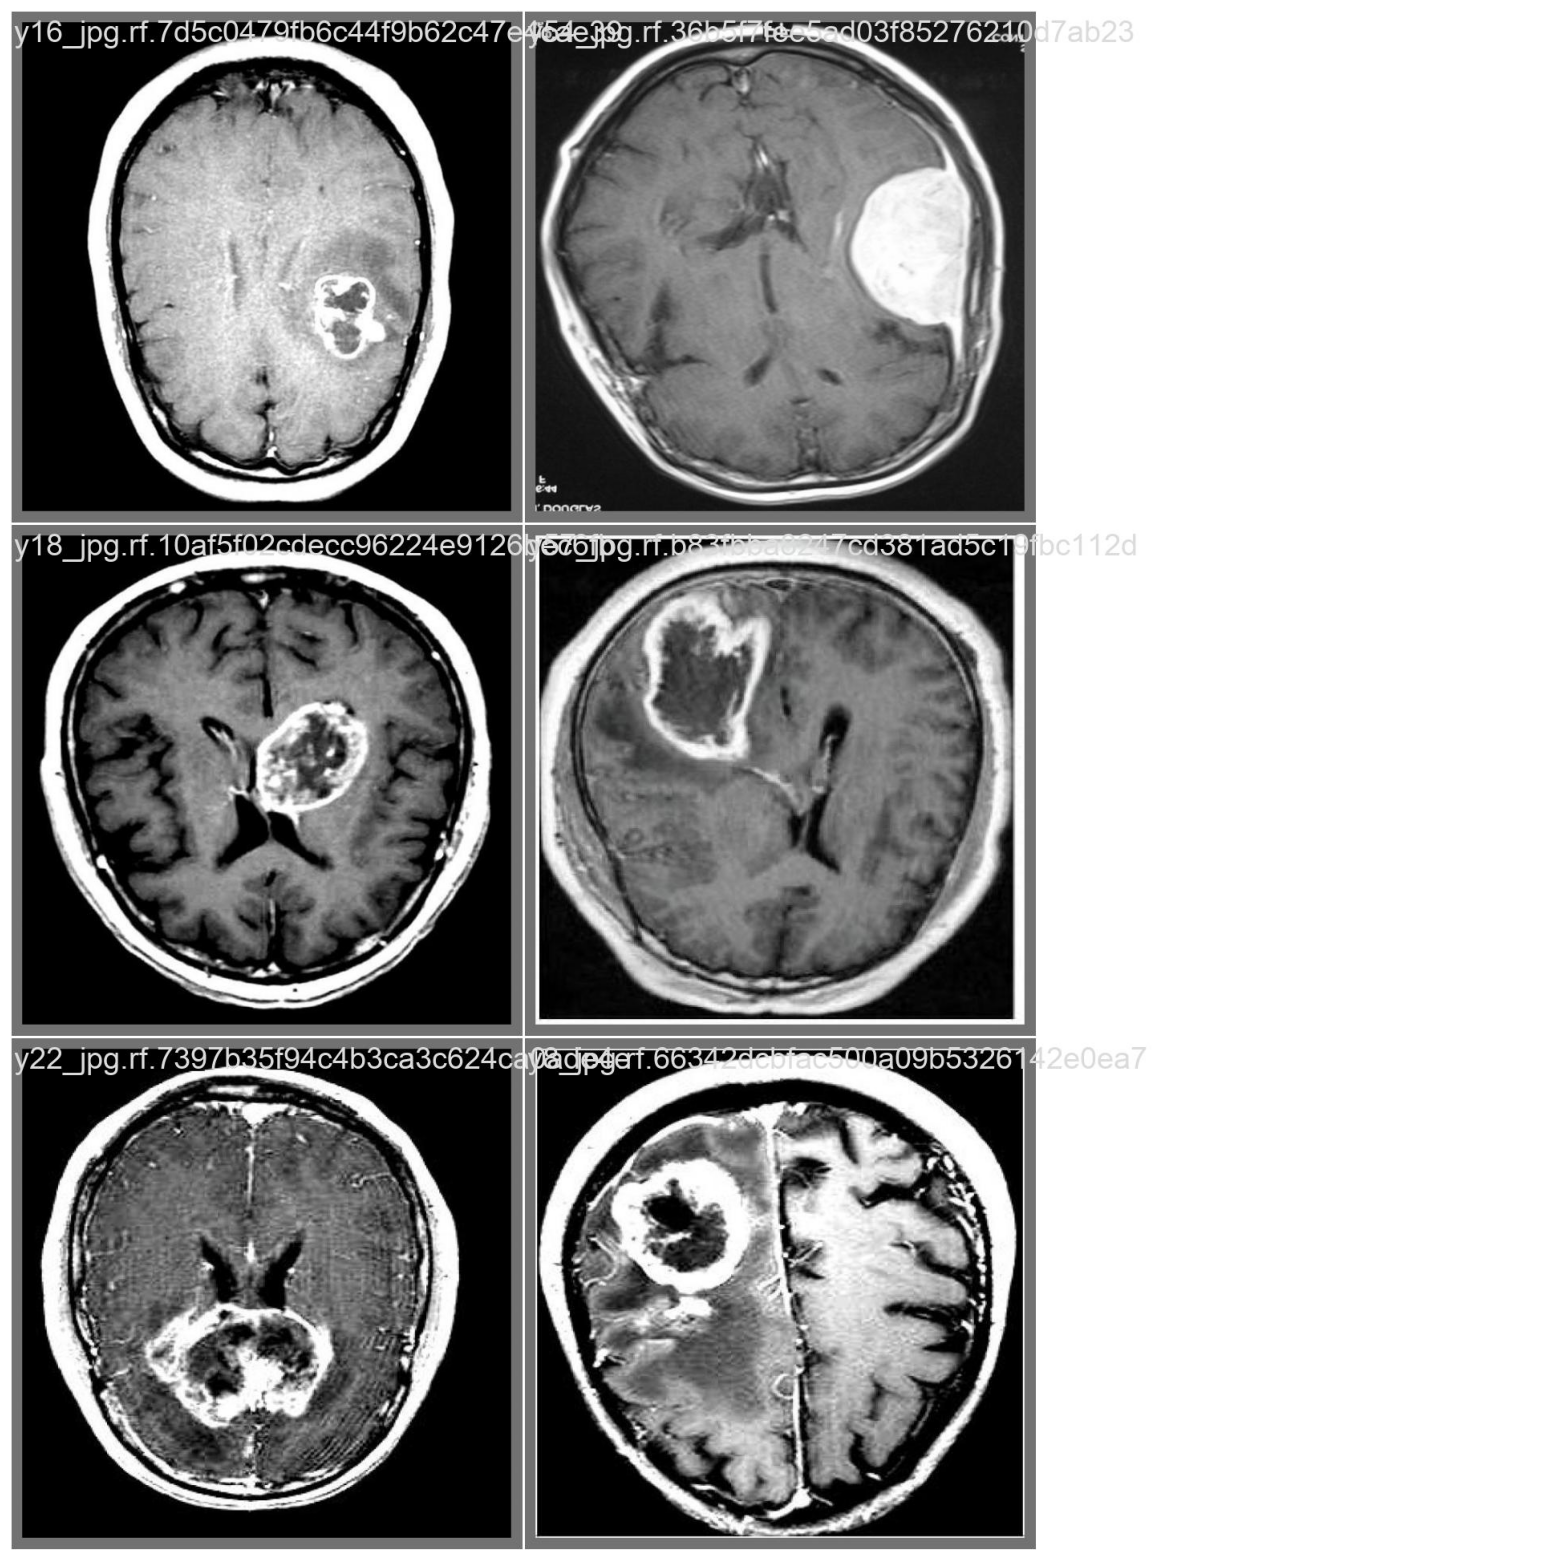

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "/content/segment-anything-2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

In [ ]:
masks = mask_generator.generate(image)

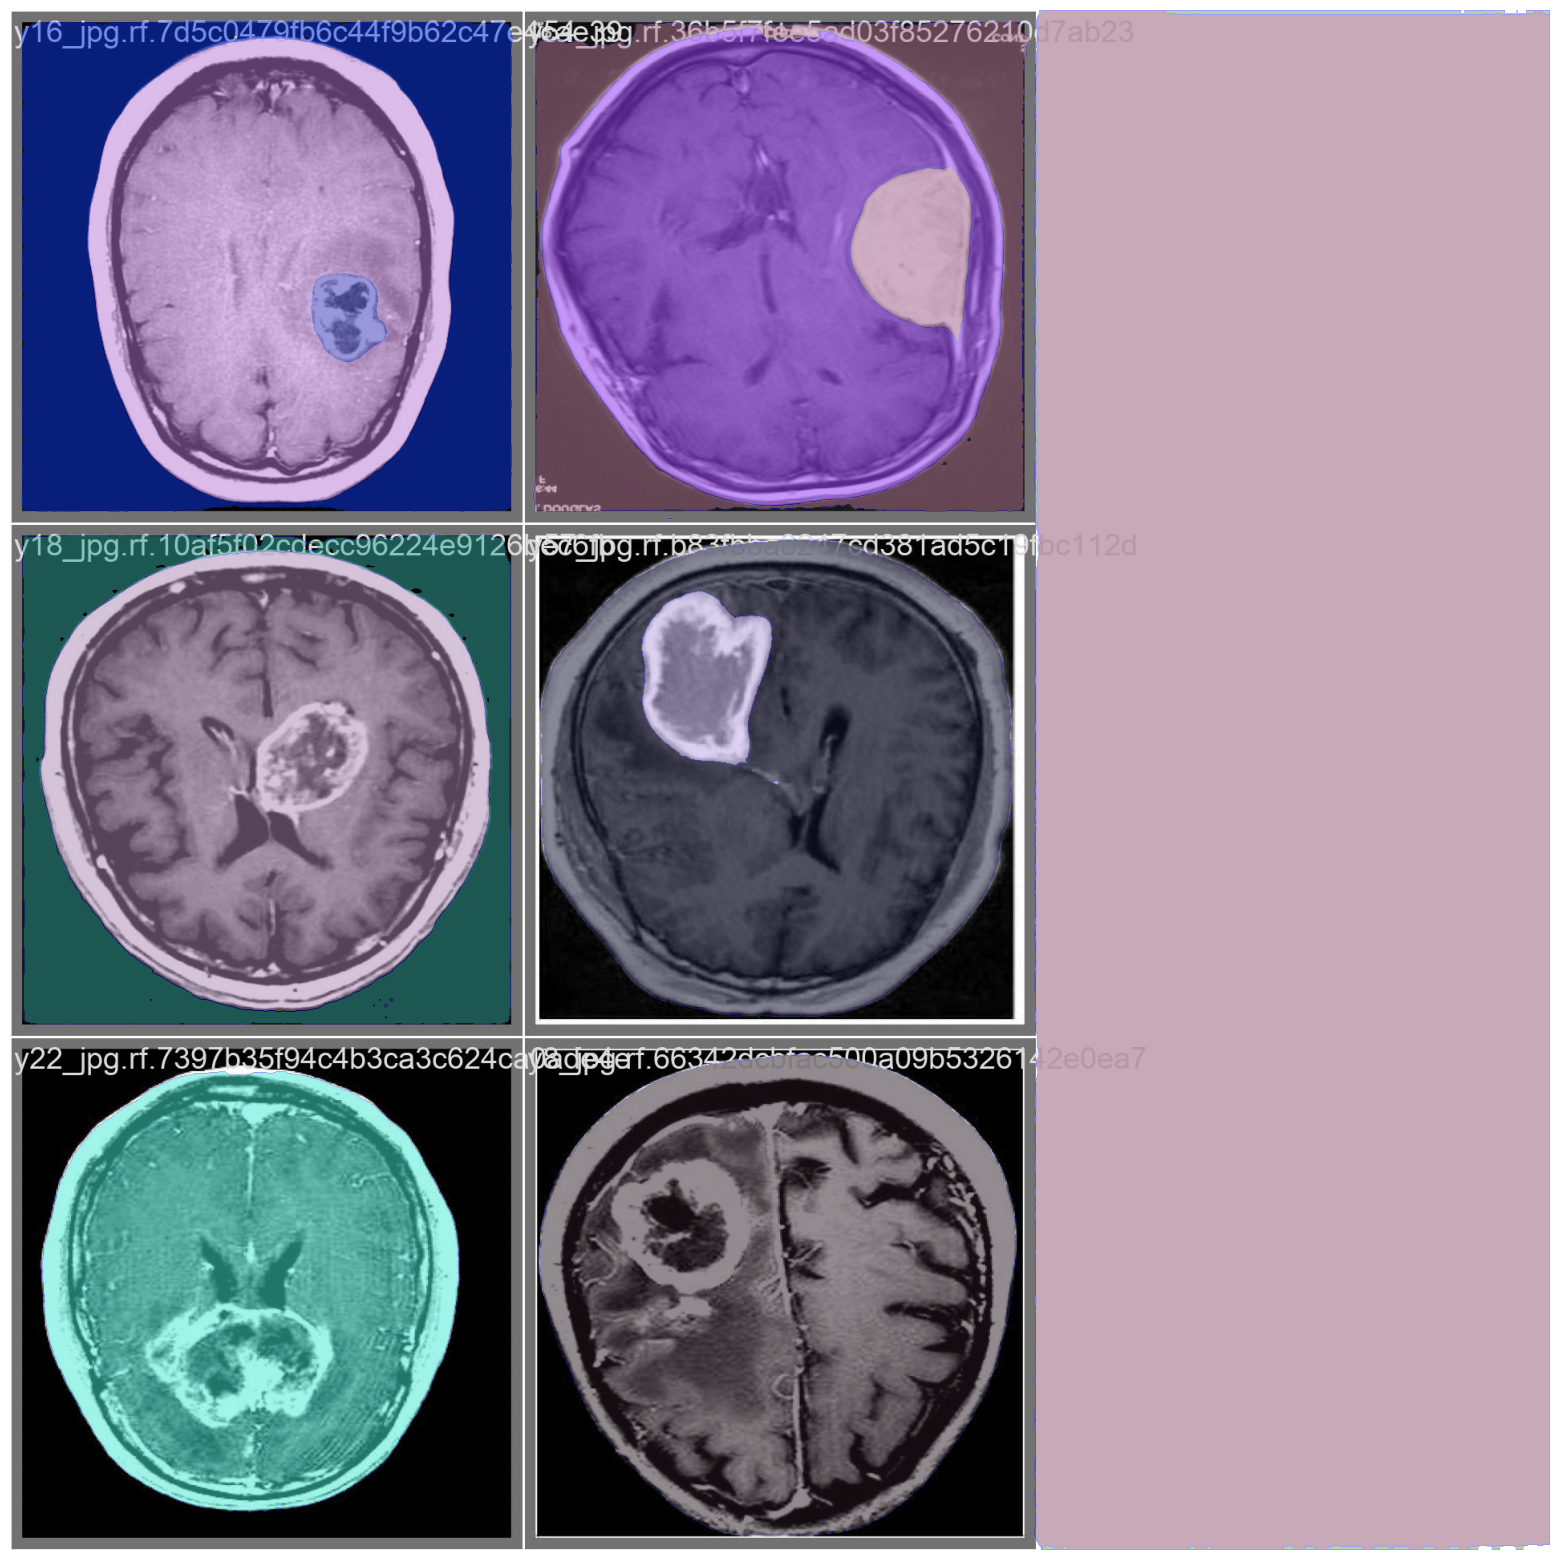

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [22]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

In [25]:
masks2 = mask_generator_2.generate(image)

OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 

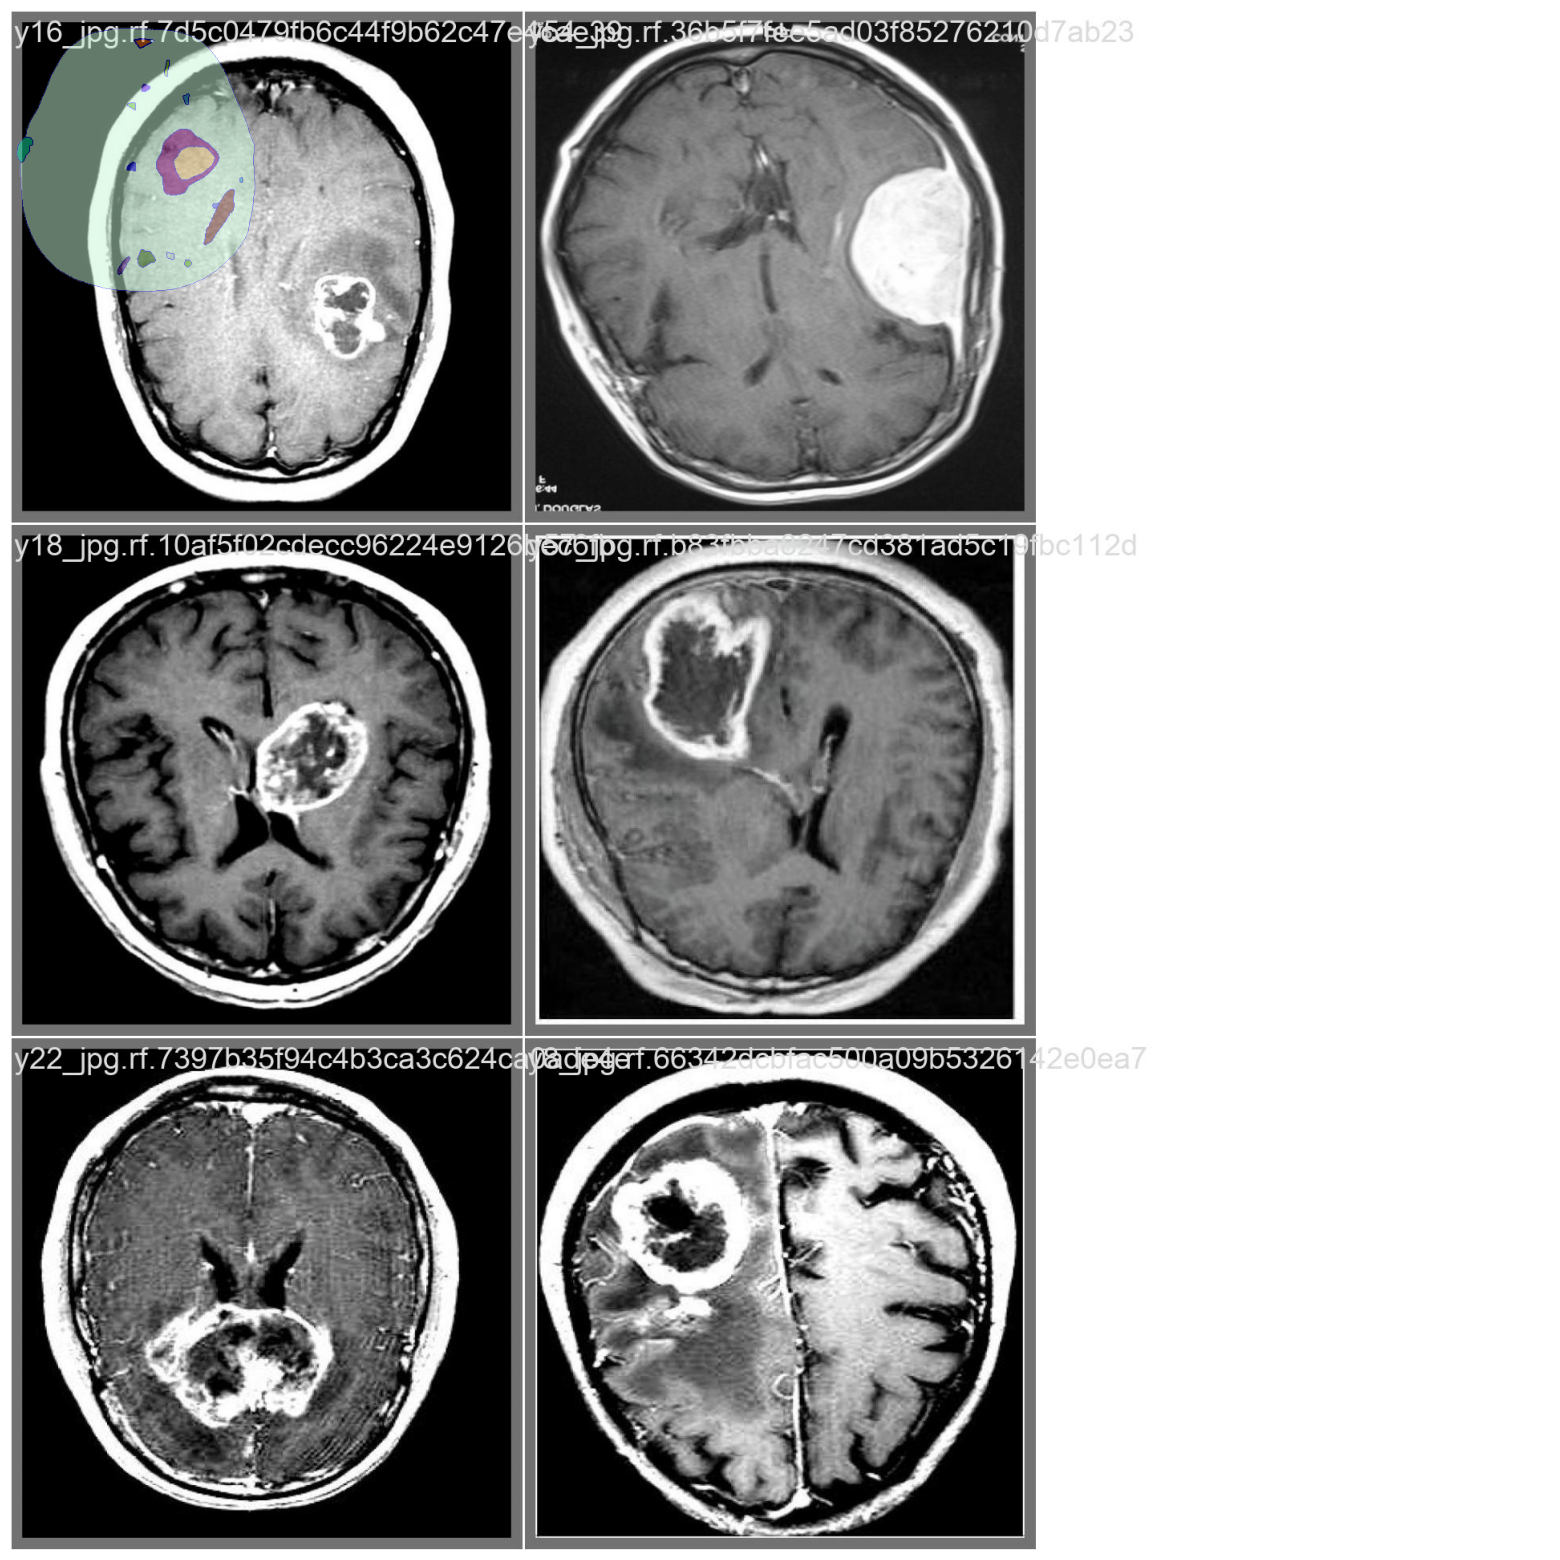

In [24]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()

In [ ]:
# Step 1: Clone the SAM 2 repository
!git clone https://github.com/facebookresearch/segment-anything-2.git

# Step 2: Navigate to the directory and install the package
%cd segment-anything-2
!pip install -e .

# Step 3: Install additional dependencies (Jupyter and Matplotlib)
!pip install -e ".[demo]"

# Step 4: Download model checkpoints
!cd checkpoints && ./download_ckpts.sh && cd ..

# Step 5: (Optional) Check if CUDA is available
import torch
torch.cuda.is_available()

# After completing the steps above, you should be able to use SAM 2 in Google Colab.


Cloning into 'segment-anything-2'...
remote: Enumerating objects: 510, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 510 (delta 152), reused 71 (delta 71), pack-reused 304 (from 1)
Receiving objects: 100% (510/510), 88.45 MiB | 16.55 MiB/s, done.
Resolving deltas: 100% (160/160), done.
/content/segment-anything-2
Obtaining file:///content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvi

Obtaining file:///content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 8.3 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=SAM_2-1.0-0.editable-cp310-cp310-linux_x86_64.whl size=12322 sha256=67a87425f38a7372ac3bce50457787bad0f5f6fe7666f419d809842c132a8070
  Stored in directory: /tmp/pip-ephem-wheel-cache-d23ifx88/wheels/7d/af/fe/c05425a1fdc391329545b53111d5cabdfc241ee07cab053945
Successfully built SAM-2
  Attempting un

True

In [ ]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

checkpoint = "/content/segment-anything-2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"
predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    predictor.set_image("/content/Y10.jpg")
    masks, _, _ = predictor.predict("detect the tumor")

NotImplementedError: Image format not supported

In [ ]:
import torch
from sam2.build_sam import build_sam2_video_predictor

# Define the paths for the checkpoint and model configuration
checkpoint = "/content/segment-anything-2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

# Build the SAM2 video predictor
predictor = build_sam2_video_predictor(model_cfg, checkpoint)

# Path to your video file
video_path = "/content/football_result (1).mp4"

# Run inference
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    # Initialize the predictor state with the video
    state = predictor.init_state(video_path)

    # Define prompts for the model (example prompts)
    # Replace with actual prompts based on your needs
    prompts = {
        'points': [[100, 150]],  # Example: list of coordinates (x, y)
        'boxes': [[50, 100, 200, 250]],  # Example: list of bounding boxes (x1, y1, x2, y2)
        'labels': [1]  # Example: labels for the prompts (1 for foreground, 0 for background)
    }

    # Add new points or boxes to the model
    frame_idx, object_ids, masks = predictor.add_new_points_or_box(state, prompts)

    # Propagate the prompts to get masklets throughout the video
    for frame_idx, object_ids, masks in predictor.propagate_in_video(state):
        # Process the output masks (e.g., save, display, or analyze)
        print(f"Frame {frame_idx}: Detected object IDs: {object_ids}, Masks: {masks}")

        # Additional code to handle masks
        # Example: Save masks as images, display, or analyze
        # You may need to convert masks to a visualizable format


NotImplementedError: Only JPEG frames are supported at this moment. For video files, you may use ffmpeg (https://ffmpeg.org/) to extract frames into a folder of JPEG files, such as 
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from 00000.jpg.